In [1]:
import compsoc.voter_model as vmodel
import compsoc.evaluate as eval
import compsoc.voting_rules as rules
from compsoc.profile import Profile
import matplotlib.pyplot as plt
import Aggregation.sampling as sp
import numpy as np
import random

game list loaded


In [2]:
# function for convertion of two formats' 
def prof_list_to_tuple(profile):
    temp = []
    for p in profile:
        temp.append(tuple(p))
    dic = dict()
    for t in temp:
        if t not in dic.keys():
            dic[t] = 1
        else:
            dic[t] += 1
    result = []
    for k in dic.keys():
        result.append((dic[k], k))
    return result

def prof_tuple_to_list(profile):
    result = []
    for i in profile:
        for j in range(i[0]):
            result.append(list(i[1]))
    random.shuffle(result)
    return result

In [3]:
# define sampling algorithm
def rumsa(profile, candidate):

    schedule = []
    for _ in range(10):
        schedule.append((0.5,0.8))
    for _ in range(10):
        schedule.append((0.3, 0.5))
    for _ in range(20):
        schedule.append((0.1, 0.05))

    temp = profile.pairs.copy()
    ballots = prof_tuple_to_list(temp)
    number_cand = len(ballots[0])
    logs = sp.theta_estimation(ballots, number_cand, iteration=40, sampling_rate=200, keep_rate=40, resampling_schedule=schedule, verbose=False)
    return logs[39]["theta_estimation"][candidate]

In [4]:
def spearman_rank_correlation(list1, list2):
    n = len(list1)
    rank_list1 = [sorted(list1).index(item) + 1 for item in list1]
    rank_list2 = [sorted(list2).index(item) + 1 for item in list2]
    d = [rank_list1[i] - rank_list2[i] for i in range(n)]
    d_squared = [i**2 for i in d]
    return 1 - (6 * sum(d_squared)) / (n * (n**2 - 1))

In [5]:
# def random rule which just return random social order
def random_rule(profile, candidate):
    return random.random()

In [6]:
test_rules = {
    "Borda": rules.borda.borda_rule,
    "Borda_gamma_0.01": rules.borda_gamma.get_borda_gamma(0.01),
    "Borda_gamma_0.25": rules.borda_gamma.get_borda_gamma(0.25),
    "Borda_gamma_0.5": rules.borda_gamma.get_borda_gamma(0.5),
    "Borda_gamma_0.75": rules.borda_gamma.get_borda_gamma(0.75),
    "Borda_gamma_0.99": rules.borda_gamma.get_borda_gamma(0.99),
    "Borda_gamma_1.00": rules.borda_gamma.get_borda_gamma(1.0),
    "Copeland": rules.copeland.copeland_rule,
    "Dowdall": rules.dowdall.dowdall_rule,
    "Simpson": rules.simpson.simpson_rule,
    "Random": random_rule,
}

In [7]:
spear_scores = []
for _ in range(10):

    # Test of Spear Coefficient of different voting rules for more candidates
    alternatives = list(range(10))
    utilities = [sp.random_normal_distribution(0, 3) for _ in range(15)]

    correct_order = sp.order_generation(utilities)

    # generate ballots
    ballots = []
    for _ in range(100):
        personal_util = [sp.random_normal_distribution(u, 1) for u in utilities]
        ballots.append(sp.order_generation(personal_util))

    profile = Profile(prof_list_to_tuple(ballots))

    schedule = []
    for _ in range(10):
        schedule.append((0.5, 0.8))
    for _ in range(10):
        schedule.append((0.3, 0.5))
    for _ in range(20):
        schedule.append((0.1, 0.05))

    answers = []
    for rule in test_rules.keys():
        ranking = profile.ranking(test_rules[rule])
        ranking = [a for (a, b) in ranking]
        answers.append(ranking)

    log = sp.theta_estimation(ballots, len(ballots[0]), 40, 200, 40, resampling_schedule=schedule, verbose=False)
    answers.append(sp.order_generation(list(log[39]['theta_estimation'])))

    spear_score = []
    for a in answers:
        spear_score.append(spearman_rank_correlation(correct_order, a))
    
    spear_scores.append(spear_score)


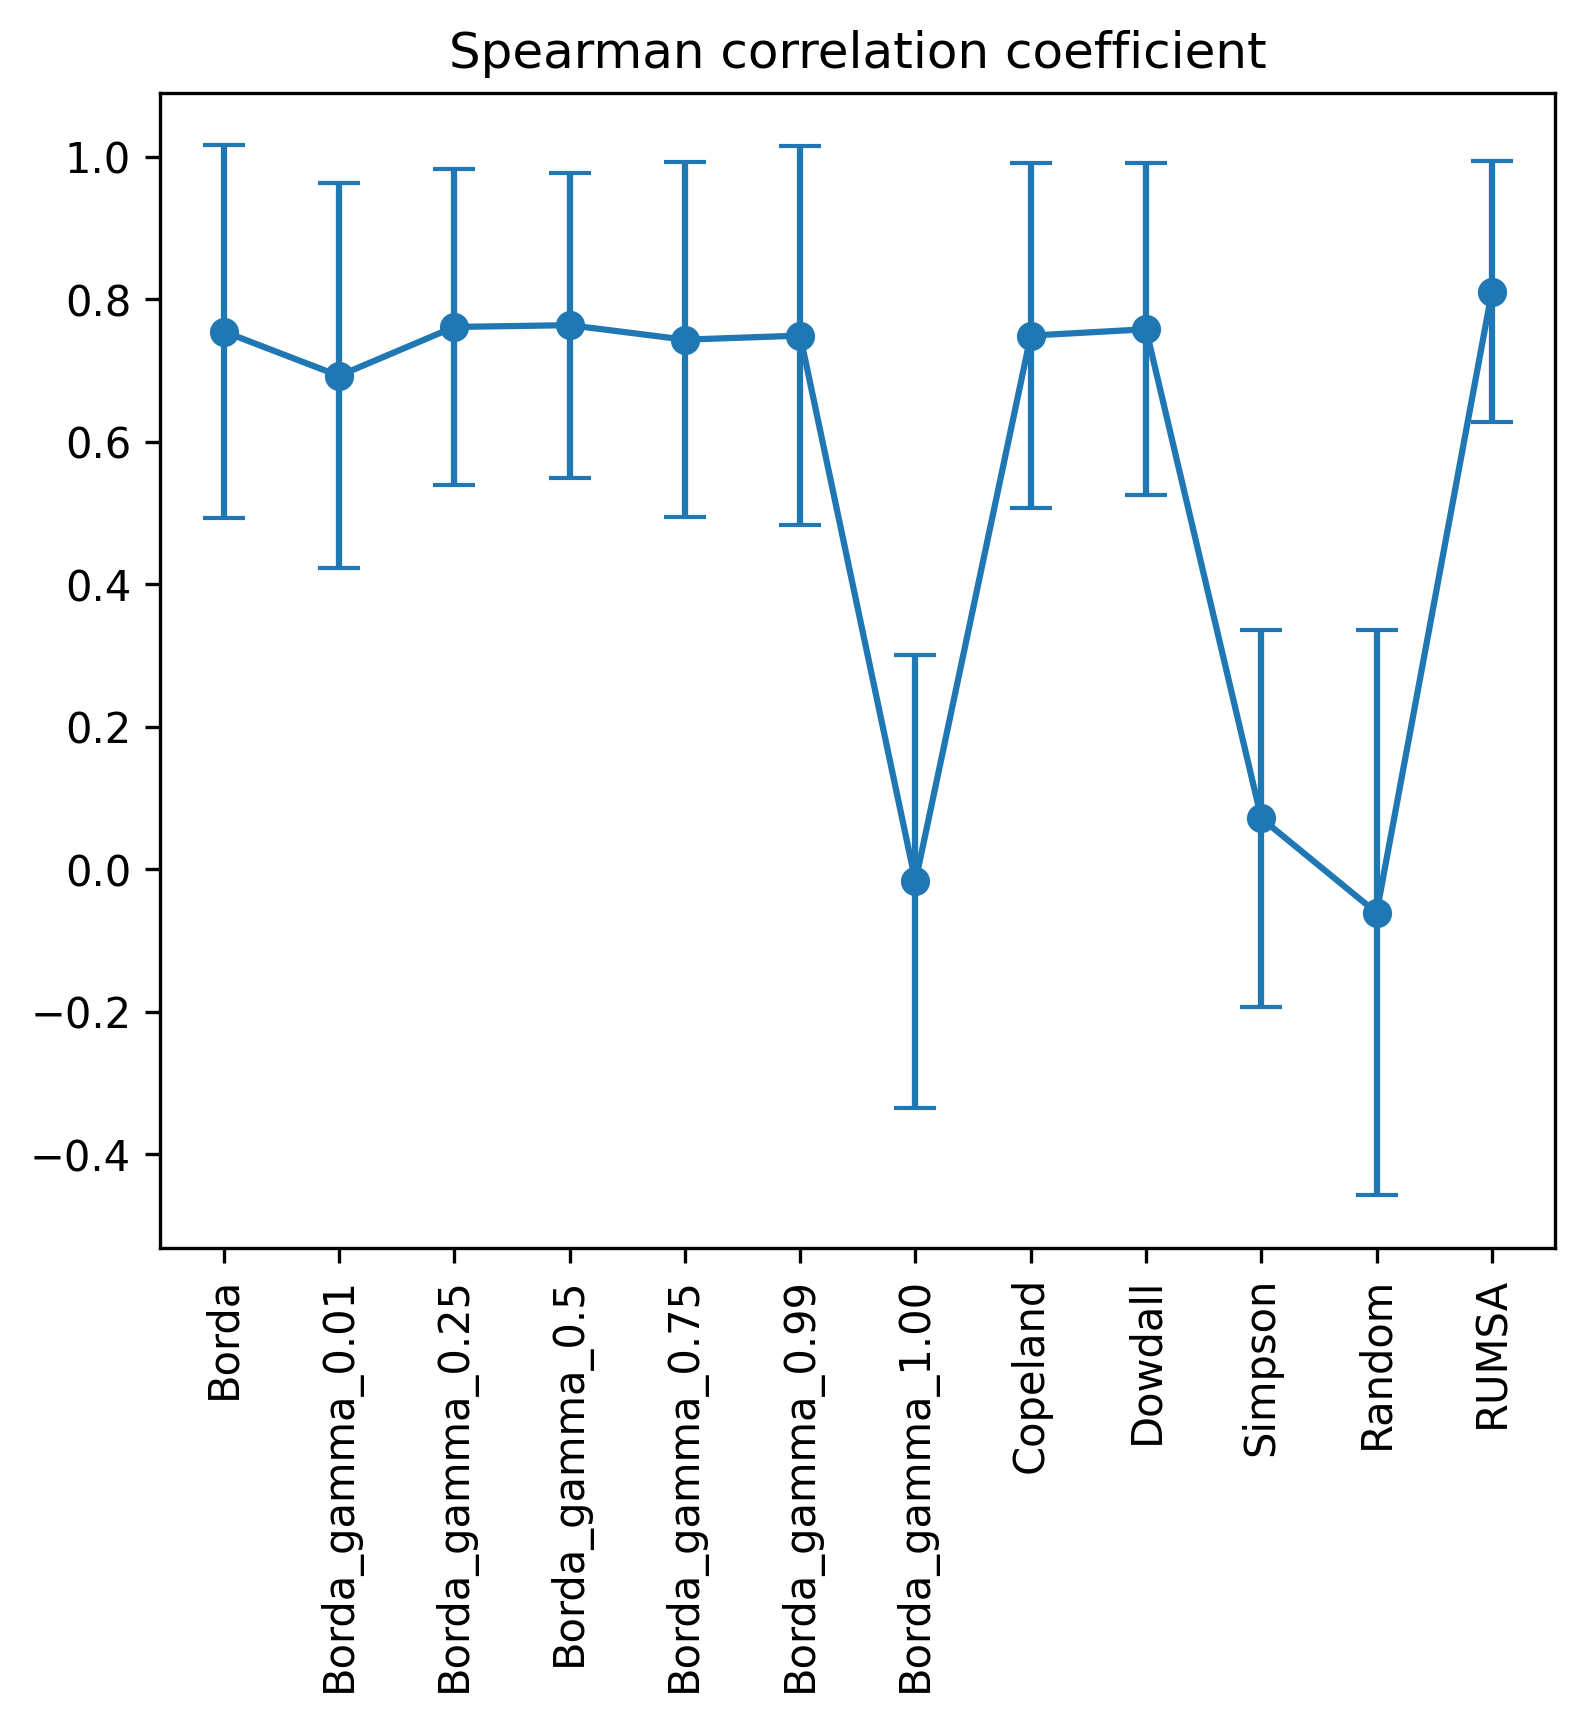

In [8]:
spear_scores = np.array(spear_scores)
avgs = np.mean(spear_scores, axis=0)
stds = np.std(spear_scores, axis=0)

plt.figure(figsize=(6, 5), dpi=300)
plt.errorbar(np.arange(len(avgs)), avgs, yerr=stds, fmt='o-', capsize=5)
plt.title("Spearman correlation coefficient")
plt.xticks(np.arange(len(avgs)), list(test_rules.keys()) + ["RUMSA"] , rotation='vertical')

plt.show()

In [9]:
spear_scores

array([[ 0.94285714,  1.        ,  1.        ,  0.94285714,  0.94285714,
         0.94285714,  0.13214286,  0.94285714,  0.94285714, -0.01071429,
        -0.52142857,  0.9       ],
       [ 1.        ,  0.65      ,  0.75714286,  0.75714286,  0.77142857,
         1.        ,  0.025     ,  0.56785714,  0.77142857,  0.06785714,
         0.05714286,  1.        ],
       [ 0.91071429,  0.81071429,  0.81071429,  0.87142857,  0.91071429,
         0.91071429, -0.04285714,  0.90714286,  0.91071429, -0.175     ,
         0.2       ,  0.90714286],
       [ 0.48214286,  0.86785714,  0.825     ,  1.        ,  0.71071429,
         0.48214286, -0.18571429,  0.48214286,  0.71071429, -0.16071429,
         0.42142857,  0.77142857],
       [ 0.56785714,  0.44642857,  0.47857143,  0.47857143,  0.42142857,
         0.51071429,  0.43214286,  0.51071429,  0.56785714,  0.36428571,
        -0.38928571,  0.51071429],
       [ 0.825     ,  0.77142857,  1.        ,  0.825     ,  0.825     ,
         0.825     , -